In [2]:
import unittest
import gvp
import matplotlib.pyplot as plt
from steerable_mlp import *
from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Testing Equivariance: Robustness in Protein Models with GVP

Equivariance is the consistency of a model's output with regard to particular input transformations. When the output is unaffected by changes made to the input, a model is said to be equivariant. For example, in computer vision tasks, an equivariant model will produce consistent predictions regardless of the translation, rotation, or scaling applied to the input image. Verifying and quantifying equivariance to rotations is crucial to establish the reliability and robustness of models that analyze protein structures.

In this demo, we investigate the equivariance to rotations of the GVP and our implementation of the steerable MLP. Our objective is to evaluate the robustness and consistency of the models' output when subjected to rotations.

To do so, we first create random `300` random nodes, with each node having `100` scalar features and `16` vector features. The edges have `32` scalar features and `1` vector feature. We can randomly generate these node and edge features. Lastly, we define the edge index, which has the information about from where to which node an edge is going.

In [4]:
n_nodes = 300
n_edges = 10000
node_dim = (100, 16)
edge_dim = (32, 1)

nodes = gvp.randn(n_nodes, node_dim, device=device)
edges = gvp.randn(n_edges, edge_dim, device=device)
edge_index = torch.randint(0, n_nodes, (2, n_edges), device=device)

print("Node scalar features", nodes[0].shape)
print("Node vector features", nodes[1].shape)
print("Edge scalar features", edges[0].shape)
print("Edge vector features", edges[1].shape)
print("Edge index", edge_index.shape)

Node scalar features torch.Size([300, 100])
Node vector features torch.Size([300, 16, 3])
Edge scalar features torch.Size([10000, 32])
Edge vector features torch.Size([10000, 1, 3])
Edge index torch.Size([2, 10000])


Now, let's enhance the clarity of the tests regarding our desired objectives. Our aim is to ensure that the scalar output features of the model remain unchanged under rotation, as scalars possess inherent rotation invariance. Additionally, we expect the vector features to exhibit rotation equivariance, implying that the model's output, after rotating the original vector input, should be identical to rotating the output obtained by passing the original vector input through the model. Or also in another representation:

$$\begin{align}
\text{Invariance:}   && \text{model}(\text{rotation}(\text{scalars})) &= \text{model}(\text{scalars})         \\
\text{Equivariance:} && \text{model}(\text{rotation}(\text{vectors})) &= \text{rotation}(\text{model}(\text{vectors})).
\end{align}$$

In [5]:
def test_equivariance_GVP(model, nodes, edges):
    
    random = torch.as_tensor(Rotation.random().as_matrix(), 
                             dtype=torch.float32, device=device)
    
    with torch.no_grad():
    
        out_s, out_v = model(nodes, edges)
        n_v_rot, e_v_rot = nodes[1] @ random, edges[1] @ random
        out_v_rot = out_v @ random
        out_s_prime, out_v_prime = model((nodes[0], n_v_rot), (edges[0], e_v_rot))
        
        assert torch.allclose(out_s, out_s_prime, atol=1e-5, rtol=1e-4)
        assert torch.allclose(out_v_rot, out_v_prime, atol=1e-5, rtol=1e-4)

Then, we define a class that has tests for the GVP, GVP with vector gating and GVP convolutional layer.

In [6]:
class EquivarianceTestGVP(unittest.TestCase):

    """
    This is a class that tests whether the GVP with and without vector gating, and
    the GVP convolutional layer are equivariant to rotation.
    """
    
    def test_gvp(self):
        model = gvp.GVP(node_dim, node_dim).to(device).eval()
        model_fn = lambda h_V, h_E: model(h_V)
        test_equivariance_GVP(model_fn, nodes, edges)
        
    def test_gvp_vector_gate(self):
        model = gvp.GVP(node_dim, node_dim, vector_gate=True).to(device).eval()
        model_fn = lambda h_V, h_E: model(h_V)
        test_equivariance_GVP(model_fn, nodes, edges)

    def test_gvp_conv_layer_vector_gate(self):
        model = gvp.GVPConvLayer(node_dim, edge_dim, vector_gate=True).to(device).eval()
        model_fn = lambda h_V, h_E: model(h_V, edge_index, h_E,
                                          autoregressive_x=h_V)
        test_equivariance_GVP(model_fn, nodes, edges)

In [7]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.226s

OK


We can conclude from this test that he scalar features are indeed invariant to rotation and the vector features are equivariant to rotation.

# Testing Equivariance: Robustness in Protein Models with steerable MLP

Now we can perform the same tests using the steerable MLP. The only thing we will need to change is how the input is handled. Since the steerable MLP works with irreducible representations, we will first define these for the nodes, edges and output.

In [8]:
# Nodes are encoded using 10 scalars (type-0) and 10 geo vector (type-1)
irreps_node = Irreps("10x0e+10x1e")
# Edges are encoded using 32 scalars and 1 geo vector (type-1)
irreps_edge = Irreps("32x0e+1x1o")
# Output is 20 scalars (type-0) and 10 geo vector (type-1)
irreps_out = Irreps("20x0e + 10x1e")

dim_emb = irreps_node.dim

print("Input irreps", irreps_node)
print("Edge irreps", irreps_edge)
print("Output irreps", irreps_out)
print("Dim embedding irreps:", dim_emb)

Input irreps 10x0e+10x1e
Edge irreps 32x0e+1x1o
Output irreps 20x0e+10x1e
Dim embedding irreps: 40


Create a random graph using random positions and edges

In [9]:
# These are the positions of the nodes
pos = torch.randn(size=(n_nodes,3))

# Node embedding
x = irreps_node.randn(n_nodes, -1)

# How these nodes are connected (doesnt matter)
edge_index = torch.randint(0, n_nodes, (2, n_edges), device=device)

# All nodes are in this "batch" -> protein structure
batch = torch.ones(size=(n_nodes,))

# Edge features: vector from source to targer
rel_pos = pos[edge_index[0]] - pos[edge_index[1]]

# Edge features in Spherical Harmonics
rel_pos_sh = o3.spherical_harmonics(irreps_edge, rel_pos, normalize=True)

# Norm of the edge features
dist = torch.linalg.vector_norm(rel_pos, dim=-1, keepdims=True)

The input is defined, so let's define the model, the convolutional layer that is equivariant to SE3 rotations. 

In [10]:
# Define model
model = ConvLayerSE3(
    irreps_node=irreps_node,
    irreps_edge=irreps_edge,
    irreps_out=irreps_out,
)

# Get the output of the random input
out = model(edge_index, x, rel_pos_sh, dist)

Generate a random 3D rotation matrix and get the right representations for the input and output irreducible representations. We need to transform all the components of the representation independently, which we visualize using a matrix.

In [11]:
rot = o3.rand_matrix()
D_in = irreps_node.D_from_matrix(rot)
D_out = irreps_out.D_from_matrix(rot)

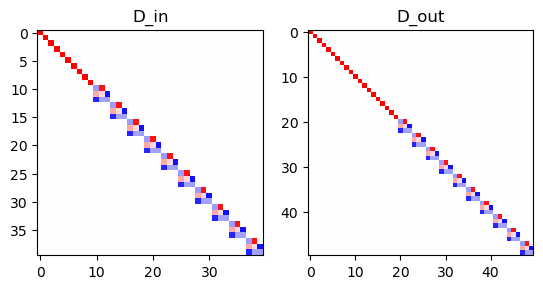

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("D_in")
ax1.imshow(D_in, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title("D_out")
ax2.imshow(D_out, cmap='bwr', vmin=-1, vmax=1);

A small example of how we can interpret this visualization is that our input irrep had 10 scalars and the output irrep had 20 scalars, which shows in the images above.

Now, we can rotate the output of the steerable convolutional layer.

In [10]:
# Rotate after
out_rot_after = out @ D_out.T

Or rotate the input of the steerable convolutional layer and rotate this output.

In [11]:
# Rotate before
rel_pos_rot = rel_pos @ rot.T
rel_pos_sh_rot = o3.spherical_harmonics(irreps_edge, rel_pos_rot, normalize=True)
out_rot_before = model(edge_index, x @ D_in.T, rel_pos_sh_rot, dist)

In [12]:
assert torch.allclose(out_rot_after, out_rot_before, rtol=1e-4, atol=1e-4, equal_nan=True)

From this, we can conclude that the model is equivariant to rotation.

# Testing the models
We can test the performance of trained models by loading the weights that gave the best performance whilst training.

In [13]:
# Change the path to the best models and data respectively

%run run_atom3d.py LBA --test best_models/LBA_lba-split=30_47.pt --lba-split 30 --data ../atom3d-data/
%run run_atom3d.py LBA --test best_models/LBA_lba-split=60_49.pt --lba-split 60 --data ../atom3d-data/

%run run_atom3d.py SMP --test best_models/SMP_smp-idx=3_46.pt --smp-idx 3 --data ../atom3d-data/
%run run_atom3d.py SMP --test best_models/SMP_smp-idx=7_48.pt --smp-idx 7 --data ../atom3d-data/
%run run_atom3d.py SMP --test best_models/SMP_smp-idx=15_48.pt --smp-idx 15 --data ../atom3d-data/

%run run_atom3d.py MSP --test best_models/MSP_batchsize1_oom6times_epoch6.pt --data ../atom3d-data/

%run run_atom3d.py PSR --test best_models/PSR_1683708337.4682121_45.pt --data ../atom3d-data/

%run run_atom3d.py RES --test best_models/RES_22.pt --data ../atom3d-data/

: 

: 